## Empirical Analysis of Similarity Sensitivity in Image Embedding Neighborhoods

Several studies suggest that Approximate Nearest Neighbor (ANN) algorithms substantially reduce the computational expense of a similarity search while maintaining high precision. However, few publications work to directly examime how similarity structure deforms under approzimation as neighborhood size varies. This notebooks conducts an emprical analysis of similarity sensitivity in image embeddings by comparing linear (exact) and approximate nearest neighbor (ANN) searches for varying k-values. 

## Step 1: Project Dependencies
Load all required libraries and verify the computational environment.

### (Optional) Install Dependencies
If the environment has not been initialiaze, install all required packages:

```bash
pip install -r requirements.txt

In [2]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt
from tqdm import tqdm
import faiss
from torch.utils.data import DataLoader
from torchvision.datasets import STL10
from torchvision import models
import os 
import json

import numpy as np
from torch.utils.data import Subset


# Detect device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("PyTorch version:", torch.__version__)
print("FAISS version:", faiss.__version__)
print("Using device:", device)

PyTorch version: 2.9.1
FAISS version: 1.12.0
Using device: cpu


## Step 2: Experiment Configuration
Define the dataset path, preprocessing pipeline, and hyperparameters used throughout the experiment.

In [2]:
# Path to STL-10 image dataset
DATA_PATH = "./data/stl10-data"

EMB_FILE = "./data/embeddings_resnet50_stl10.npy"
EMB_CHUNK_DIR = "./data/emb_chunks"

# Batch size for embedding extraction
BATCH_SIZE = 32


# HNSW parameters
M = 32           # graph connectivity (higher = more accurate, slower)
EF_CONSTRUCTION = 200
EF_SEARCH = 50   # controls ANN accuracy during search

# Data sample size (to deal with computational limits of linear search) 
DATASET_TARGET_SIZE = 10_000 

# Preprocessing pipeline: Transforms/Normalizes images according 
# to the mean and standard deviation of ImageNet.
transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

# KNN Search Parameters
K_MIN  = 10
K_MAX  = 250
K_STEP = 10

## Step 3: Load Dataset
Load the STL-10 dataset and verify its size, structure, and sample images.

100%|██████████| 2.64G/2.64G [08:16<00:00, 5.31MB/s] 


Full STL-10 dataset loaded:
 - Number of samples: 100000
 - Image tensor size: torch.Size([3, 224, 224])

Using subsampled dataset of size: 10000


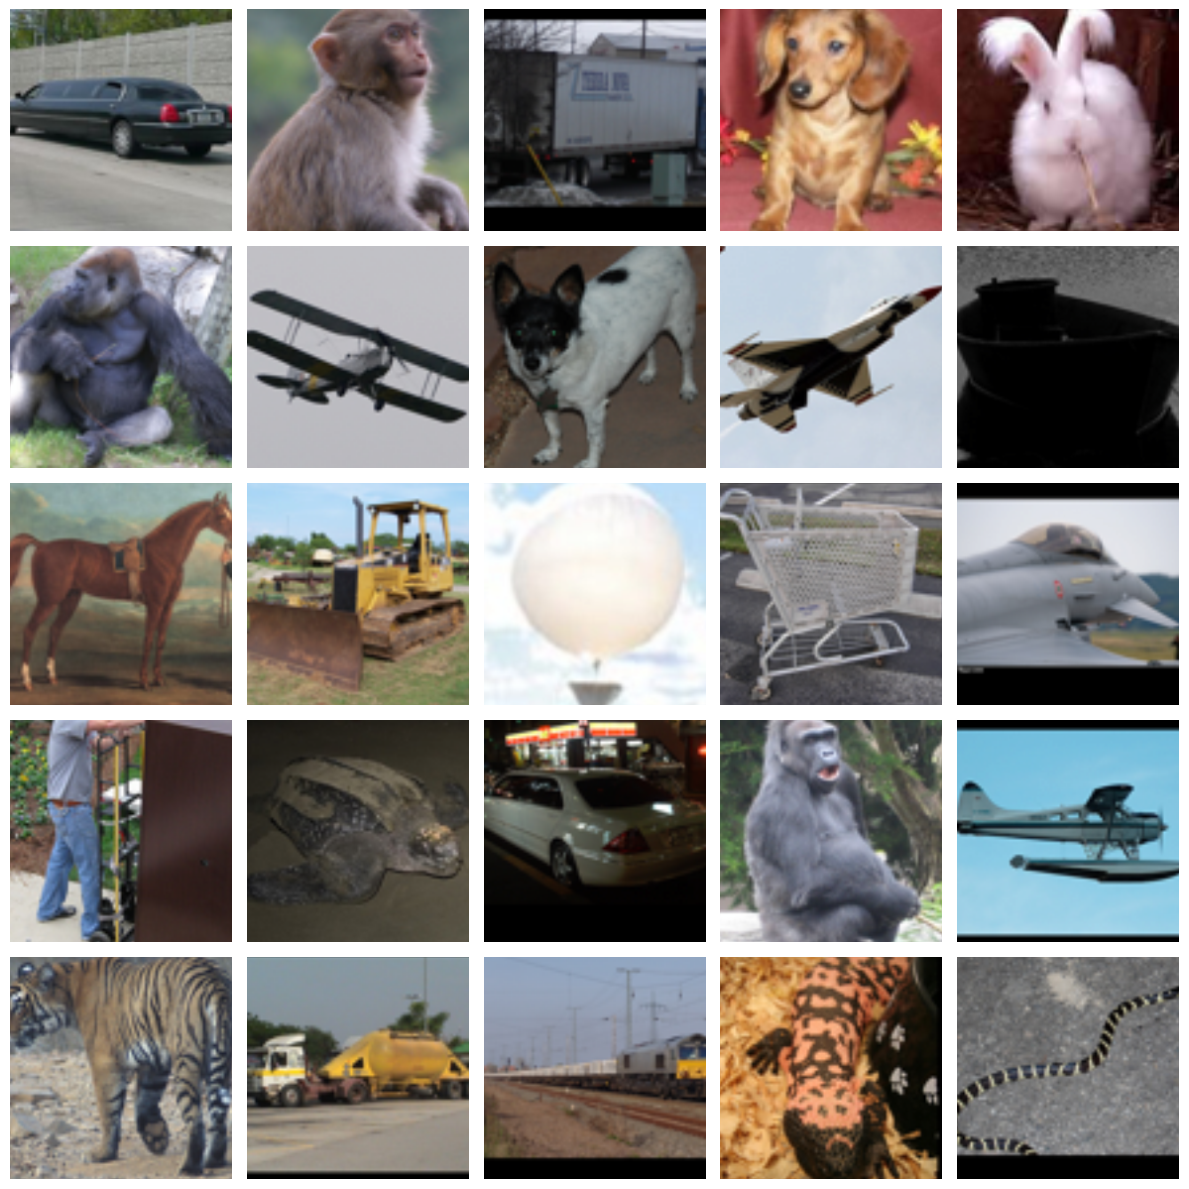

In [3]:
# --- Load STL-10 (100k unlabeled natural images) ---
# We will later subsample to 10k for full linear search feasibility.

dataset = STL10(
    root=DATA_PATH,
    split="unlabeled",      # 100,000 natural images
    download=True,
    transform=transform
)

print("Full STL-10 dataset loaded:")
print(" - Number of samples:", len(dataset))
print(" - Image tensor size:", dataset[0][0].shape)

N = len(dataset)
indices = np.random.choice(N, DATASET_TARGET_SIZE, replace=False)
dataset_10k = Subset(dataset, indices)

print(f"\nUsing subsampled dataset of size: {len(dataset_10k)}")

# --- DataLoader for the 10k dataset ---
loader = DataLoader(
    dataset_10k,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

def show_grid(ds, rows=5, cols=5):
    """Display a grid of sample images from the dataset."""
    num = rows * cols
    fig, axes = plt.subplots(rows, cols, figsize=(12, 12))

    for idx in range(num):
        r = idx // cols
        c = idx % cols

        img, _ = ds[idx]

        # Undo normalization
        disp = img.permute(1, 2, 0).numpy()
        disp = disp * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        disp = np.clip(disp, 0, 1)

        axes[r][c].imshow(disp)
        axes[r][c].axis("off")

    plt.tight_layout()
    plt.show()

# Show 25 samples
show_grid(dataset_10k, rows=5, cols=5)



## Step 4: Load Pre-trained ResNet-50 Model
Load an ImageNet-trained ResNet-50 and expose its penultimate layer for embedding extraction.

In [4]:
# Load pretrained ResNet-50 (ImageNet-trained weights)
resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

# Remove the final classification layer to expose penultimate embeddings
embedding_model = torch.nn.Sequential(*list(resnet.children())[:-1])
embedding_model.to(device)
embedding_model.eval()

# Embedding extraction function
def extract_embeddings(batch):
    with torch.no_grad():
        feats = embedding_model(batch.to(device))
        # Output shape: (batch_size, 2048, 1, 1) → squeeze to (batch_size, 2048)
        feats = feats.squeeze(-1).squeeze(-1)
    return feats.cpu().numpy().astype("float32")

print("Embedding dimension:", 2048)

Embedding dimension: 2048


## Step 5: Generate Image Embeddings
Extract 2048-dimensional ResNet-50 embeddings for all images, saving batch-level chunks to disk and automatically skipping extraction on future runs if a complete embedding file already exists.

In [5]:
# -------------------------------------------------------
# 1. If the final embedding file exists, load & skip work
# -------------------------------------------------------
if os.path.exists(EMB_FILE):
    print(f"Embeddings already exist → loading {EMB_FILE}")
    embeddings = np.load(EMB_FILE)
    print("Loaded:", embeddings.shape)
    skip_embedding = True
else:
    skip_embedding = False

# -------------------------------------------------------
# 2. Otherwise, extract embeddings batch-by-batch and save
# -------------------------------------------------------
if not skip_embedding:
    print("No saved embeddings found → generating now...")
    os.makedirs(EMB_CHUNK_DIR, exist_ok=True)

    chunk_paths = []
    chunk_id = 0

    for batch, _ in tqdm(loader):
        emb = extract_embeddings(batch)        # (batch, 2048)
        chunk_path = os.path.join(EMB_CHUNK_DIR, f"chunk_{chunk_id}.npy")
        np.save(chunk_path, emb.astype("float32"))
        chunk_paths.append(chunk_path)
        chunk_id += 1

    print(f"Saved {len(chunk_paths)} chunks. Stitching...")

    # Stitch all chunks into the final embedding array
    all_chunks = [np.load(p) for p in chunk_paths]
    embeddings = np.vstack(all_chunks).astype("float32")

    np.save(EMB_FILE, embeddings)
    print(f"Final embedding matrix saved → {EMB_FILE}")
    print("Shape:", embeddings.shape)

print("Embeddings ready for downstream analysis.")


No saved embeddings found → generating now...


100%|██████████| 313/313 [00:12<00:00, 25.03it/s]


Saved 313 chunks. Stitching...
Final embedding matrix saved → ./data/embeddings_resnet50_stl10.npy
Shape: (10000, 2048)
Embeddings ready for downstream analysis.


## Step 6: Build Linear Search Index
Build a brute-force FAISS index to compute exact nearest neighbors under the chosen similarity metric.

In [6]:
# collect dimension of the embeddings 
d = embeddings.shape[1] 

# Create a brute-force exact index that ranks 
# neighbors by Euclidean distance.
index_exact = faiss.IndexFlatL2(d)

# Add embeddings to the index
index_exact.add(embeddings)

print("Linear (exact) index built.")
print("Index size (should equal number of embeddings):", index_exact.ntotal)




Linear (exact) index built.
Index size (should equal number of embeddings): 10000


## Step 7: Build Approximate Nearest Neighbors (ANN) Index 
Build an HNSW (Hierarchical Navigable Small World) ANN index to perform fast approximate nearest-neighbor search under the chosen similarity metric.

In [7]:
# get embedding dimension (needed by FAISS index)
d = embeddings.shape[1]

# Build an HNSW graph index that ranks 
# neighbors using Euclidean distance
index_ann = faiss.IndexHNSWFlat(d, M, faiss.METRIC_L2)

# set graph construction hyperparameter (larger = higher quality, slower build)
index_ann.hnsw.efConstruction = EF_CONSTRUCTION

# set search-time accuracy hyperparameter (larger = higher recall, slower search)
index_ann.hnsw.efSearch = EF_SEARCH

# add all embedding vectors to the ANN index
index_ann.add(embeddings)

print("ANN index built.")
print("Index size:", index_ann.ntotal)
print("HNSW parameters: M =", M, " efSearch =", EF_SEARCH)




ANN index built.
Index size: 10000
HNSW parameters: M = 32  efSearch = 50


In [8]:
## Step 7 — Compute Full Exact Neighbor Structure
N = len(embeddings)
print(f"Computing FULL exact neighbors (k = {N})... this may take a while.")

D_exact_full, I_exact_full = index_exact.search(embeddings, N)

print("Full exact search complete.")
print("Exact neighbor matrix shape:", I_exact_full.shape)

Computing FULL exact neighbors (k = 10000)... this may take a while.
Full exact search complete.
Exact neighbor matrix shape: (10000, 10000)


## Step 8: Linear vs ANN Experiment
Run a k-sweep experiment comparing exact vs. ANN neighbors by measuring neighborhood overlap and similarity decay across different k values.

In [9]:
## Step 8 — Run ANN vs Exact k-Sweep Comparison (Overlap, Decay, LID, Barycenter Shift)

def compute_lid(distances):
    """
    distances: array of shape (k,) sorted ascending.
    Returns Local Intrinsic Dimensionality (LID) using MLE estimator.
    """
    d_k = distances[-1] + 1e-12
    ratios = distances[:-1] / d_k
    return -1.0 / np.mean(np.log(ratios + 1e-12))


K_VALUES = list(range(K_MIN, K_MAX + 1, K_STEP))
print(f"Running k-sweep from {K_MIN} to {K_MAX} step {K_STEP} ({len(K_VALUES)} values).")

results = {}

for k in K_VALUES:
    print(f"\nEvaluating k = {k}")

    # --- Exact neighbors ---
    D_exact = D_exact_full[:, :k]
    I_exact = I_exact_full[:, :k]

    # --- ANN neighbors ---
    D_ann, I_ann = index_ann.search(embeddings, k)

    # ---------------------------------------
    # 1. Overlap (set-level distortion)
    # ---------------------------------------
    overlaps = []
    for i in range(len(embeddings)):
        overlaps.append(len(set(I_exact[i]) & set(I_ann[i])) / k)

    mean_overlap = float(np.mean(overlaps))
    std_overlap  = float(np.std(overlaps))

    # ---------------------------------------
    # 2. Similarity Decay (radial geometry)
    # ---------------------------------------
    kth_exact = float(np.mean(D_exact[:, -1]))
    kth_ann   = float(np.mean(D_ann[:, -1]))

    # ---------------------------------------
    # 3. LID (topological distortion)
    # ---------------------------------------
    lids_exact = [compute_lid(D_exact[i]) for i in range(len(embeddings))]
    lids_ann   = [compute_lid(D_ann[i])   for i in range(len(embeddings))]

    lid_exact_mean = float(np.mean(lids_exact))
    lid_ann_mean   = float(np.mean(lids_ann))
    lid_diff_mean  = float(lid_ann_mean - lid_exact_mean)

    # ---------------------------------------
    # 4. Barycenter Shift (spatial distortion)
    # ---------------------------------------
    shifts = []
    for i in range(len(embeddings)):
        mu_exact = embeddings[I_exact[i]].mean(axis=0)
        mu_ann   = embeddings[I_ann[i]].mean(axis=0)
        shift = np.linalg.norm(mu_exact - mu_ann)
        shifts.append(shift)

    bary_shift_mean = float(np.mean(shifts))

    # ---------------------------------------
    # Store everything
    # ---------------------------------------
    results[k] = {
        "mean_overlap": mean_overlap,
        "std_overlap": std_overlap,
        "similarity_k_exact": kth_exact,
        "similarity_k_ann": kth_ann,
        "lid_exact_mean": lid_exact_mean,
        "lid_ann_mean": lid_ann_mean,
        "lid_diff_mean": lid_diff_mean,
        "barycenter_shift_mean": bary_shift_mean,
    }

    # --- Logging ---
    print(f"  overlap: {mean_overlap:.4f} ± {std_overlap:.4f}")
    print(f"  similarity decay (exact): {kth_exact:.4f}")
    print(f"  similarity decay (ANN):   {kth_ann:.4f}")
    print(f"  LID exact: {lid_exact_mean:.3f} | LID ann: {lid_ann_mean:.3f} | Δ {lid_diff_mean:.3f}")
    print(f"  barycenter shift (mean): {bary_shift_mean:.6f}")


Running k-sweep from 10 to 250 step 10 (25 values).

Evaluating k = 10
  overlap: 0.9953 ± 0.0370
  similarity decay (exact): 81.7295
  similarity decay (ANN):   81.7845
  LID exact: 0.394 | LID ann: 0.405 | Δ 0.011
  barycenter shift (mean): 0.045685

Evaluating k = 20
  overlap: 0.9934 ± 0.0341
  similarity decay (exact): 91.4200
  similarity decay (ANN):   91.4838
  LID exact: 0.770 | LID ann: 0.712 | Δ -0.058
  barycenter shift (mean): 0.055993

Evaluating k = 30
  overlap: 0.9912 ± 0.0344
  similarity decay (exact): 97.3155
  similarity decay (ANN):   97.4044
  LID exact: 1.098 | LID ann: 0.989 | Δ -0.108
  barycenter shift (mean): 0.067646

Evaluating k = 40
  overlap: 0.9880 ± 0.0368
  similarity decay (exact): 101.5533
  similarity decay (ANN):   101.6802
  LID exact: 1.389 | LID ann: 1.240 | Δ -0.149
  barycenter shift (mean): 0.083935

Evaluating k = 50
  overlap: 0.9839 ± 0.0401
  similarity decay (exact): 104.9098
  similarity decay (ANN):   105.0867
  LID exact: 1.653 | LI

/home/morgan-cooper/miniconda3/envs/similarity-exp/lib/python3.10/site-packages/numpy/_core/_methods.py:135: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


  overlap: 0.8470 ± 0.0846
  similarity decay (exact): 123.2803
  similarity decay (ANN):   inf
  LID exact: 3.733 | LID ann: 3.227 | Δ -0.507
  barycenter shift (mean): 0.421035

Evaluating k = 180
  overlap: 0.8336 ± 0.0869
  similarity decay (exact): 124.1437
  similarity decay (ANN):   inf
  LID exact: 3.856 | LID ann: 3.306 | Δ -0.550
  barycenter shift (mean): 0.444110

Evaluating k = 190
  overlap: 0.8207 ± 0.0888
  similarity decay (exact): 124.9681
  similarity decay (ANN):   inf
  LID exact: 3.973 | LID ann: 3.379 | Δ -0.594
  barycenter shift (mean): 0.467092

Evaluating k = 200
  overlap: 0.8078 ± 0.0904
  similarity decay (exact): 125.7524
  similarity decay (ANN):   inf
  LID exact: 4.086 | LID ann: 3.444 | Δ -0.643
  barycenter shift (mean): 0.491551

Evaluating k = 210
  overlap: 0.7952 ± 0.0918
  similarity decay (exact): 126.5037
  similarity decay (ANN):   inf
  LID exact: 4.195 | LID ann: 3.501 | Δ -0.694
  barycenter shift (mean): 0.515870

Evaluating k = 220
  ove

## Step 9: Save Results

In [10]:
# save results to a JSON file
with open("k_sweep_results.json", "w") as f:
    json.dump(results, f, indent=4)

print("\nSaved results to k_sweep_results.json")


Saved results to k_sweep_results.json


In [3]:
with open("k_sweep_results.json", "r") as f:
    results = json.load(f)

print("Loaded results for ks:", list(results.keys()))

Loaded results for ks: ['10', '20', '30', '40', '50', '60', '70', '80', '90', '100', '110', '120', '130', '140', '150', '160', '170', '180', '190', '200', '210', '220', '230', '240', '250']


## Step 10: Visualize Results

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure sorted k-values
ks = sorted(results.keys(), key=lambda x: int(x))

# Extract metrics
mean_overlap = [results[k]["mean_overlap"] for k in ks]
std_overlap  = [results[k]["std_overlap"]  for k in ks]

sim_exact = [results[k]["similarity_k_exact"] for k in ks]
sim_ann   = [results[k]["similarity_k_ann"]   for k in ks]

lid_exact = [results[k]["lid_exact_mean"] for k in ks]
lid_ann   = [results[k]["lid_ann_mean"]   for k in ks]
lid_diff  = [results[k]["lid_diff_mean"]  for k in ks]

bary_shift = [results[k]["barycenter_shift_mean"] for k in ks]


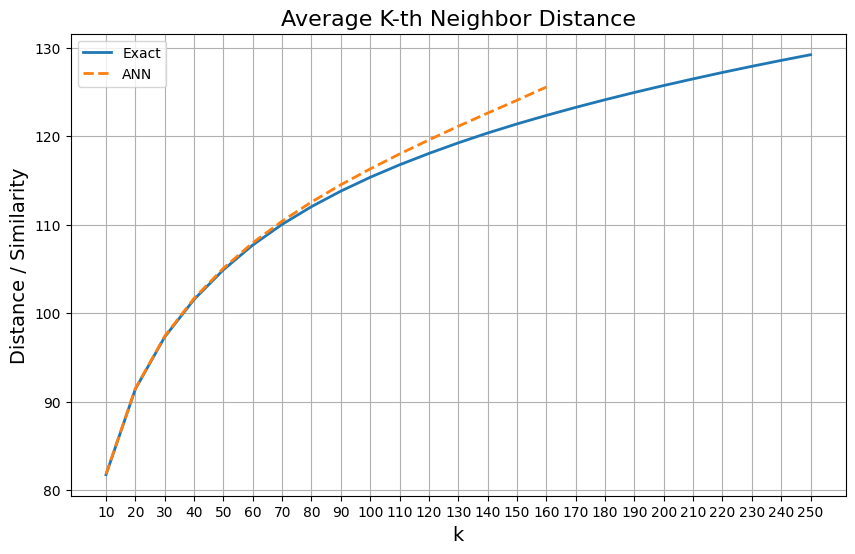

In [8]:
plt.figure(figsize=(10, 6))

# Exact: solid line
plt.plot(ks, sim_exact, linestyle="-", linewidth=2, label="Exact")

# ANN: dashed line
plt.plot(ks, sim_ann, linestyle="--", linewidth=2, label="ANN")

plt.title("Average K-th Neighbor Distance", fontsize=16)
plt.xlabel("k", fontsize=14)
plt.ylabel("Distance / Similarity", fontsize=14)
plt.legend()
plt.grid(True)
plt.show()



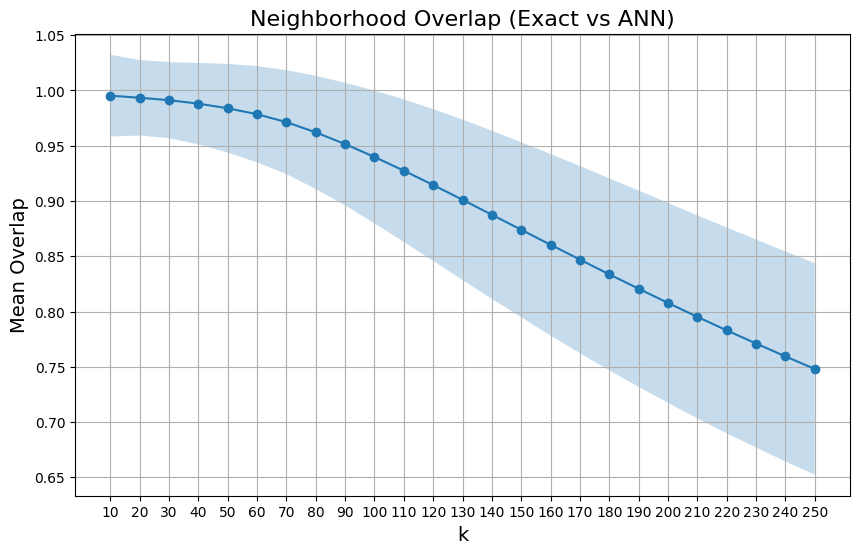

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(ks, mean_overlap, marker="o")
plt.fill_between(
    ks,
    np.array(mean_overlap) - np.array(std_overlap),
    np.array(mean_overlap) + np.array(std_overlap),
    alpha=0.25
)
plt.title("Neighborhood Overlap (Exact vs ANN)", fontsize=16)
plt.xlabel("k", fontsize=14)
plt.ylabel("Mean Overlap", fontsize=14)
plt.grid(True)
plt.show()


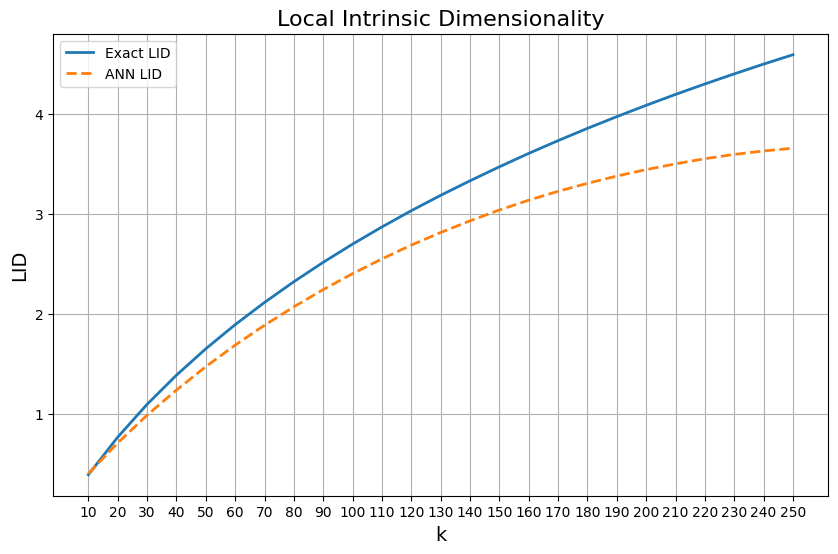

In [15]:
plt.figure(figsize=(10, 6))

# Exact LID: solid line
plt.plot(ks, lid_exact, linestyle="-", linewidth=2, label="Exact LID")

# ANN LID: dashed line
plt.plot(ks, lid_ann, linestyle="--", linewidth=2, label="ANN LID")

plt.title("Local Intrinsic Dimensionality", fontsize=16)
plt.xlabel("k", fontsize=14)
plt.ylabel("LID", fontsize=14)
plt.legend()
plt.grid(True)
plt.show()



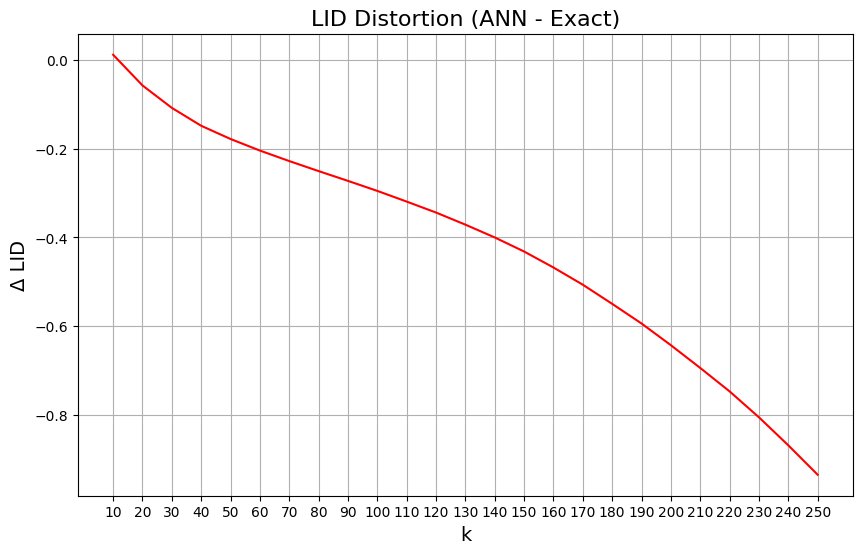

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(ks, lid_diff, marker="", color="red")
plt.title("LID Distortion (ANN - Exact)", fontsize=16)
plt.xlabel("k", fontsize=14)
plt.ylabel("Δ LID", fontsize=14)
plt.grid(True)
plt.show()


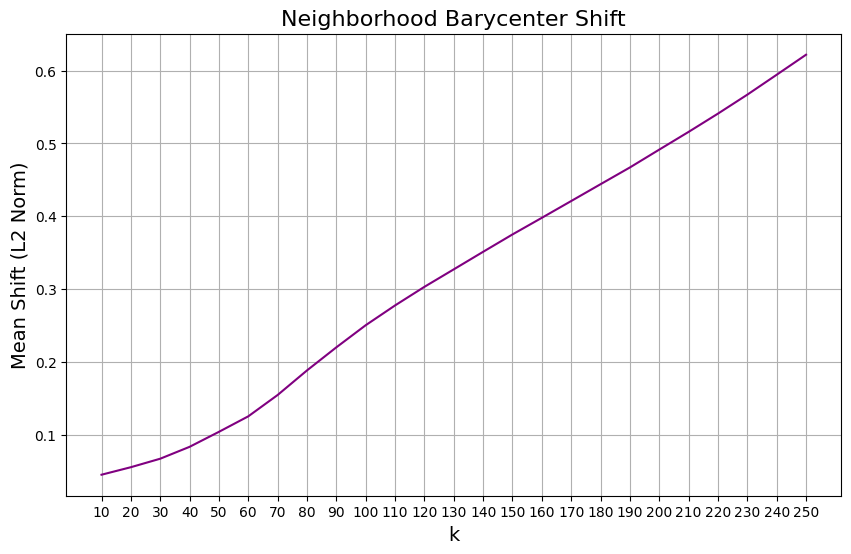

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(ks, bary_shift, marker="", color="purple")
plt.title("Neighborhood Barycenter Shift", fontsize=16)
plt.xlabel("k", fontsize=14)
plt.ylabel("Mean Shift (L2 Norm)", fontsize=14)
plt.grid(True)
plt.show()
